In [1]:
from membership_inference import DataSet, ShadowModel, AttackerModel, Membership_Inference

In [14]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Check GPU

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Load data

In [4]:
# トレーニングデータをダウンロード
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
# テストデータをダウンロード
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
X_train = trainset.data
y_train = np.array(trainset.targets)

X_test = testset.data
y_test = np.array(testset.targets)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


In [6]:
victim_idx = random.sample(range(X_train.shape[0]), k=2000)
attack_idx = random.sample(range(X_test.shape[0]), k=6000)
shadow_idx = attack_idx[:4000]
eval_idx = attack_idx[4000:]

X_victim = X_train[victim_idx]
y_victim = y_train[victim_idx]

X_shadow = X_test[shadow_idx]
y_shadow = y_test[shadow_idx]

X_eval = X_test[eval_idx]
y_eval = y_test[eval_idx]

print(X_victim.shape, y_victim.shape)
print(X_shadow.shape, y_shadow.shape)
print(X_eval.shape, y_eval.shape)

(2000, 32, 32, 3) (2000,)
(4000, 32, 32, 3) (4000,)
(2000, 32, 32, 3) (2000,)


In [7]:
# ToTensor：画像のグレースケール化（RGBの0~255を0~1の範囲に正規化）、Normalize：Z値化（RGBの平均と標準偏差を0.5で決め打ちして正規化）
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

victimset = DataSet(X_victim, y_victim, transform=transform)
victimloader = torch.utils.data.DataLoader(victimset, batch_size=4, shuffle=True, num_workers=2)

valset = DataSet(X_eval, y_eval, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=4, shuffle=True, num_workers=2)

In [8]:
X_victim.shape

(2000, 32, 32, 3)

# Define and Train a victim Model

In [9]:
# CNNを実装する
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1) 
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.L1 = nn.Linear(2048, 10) # 10クラス分類

    def forward(self, x):
        # 3ch > 64ch, shape 32 x 32 > 16 x 16
        x = self.conv1(x) # [64,32,32]
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # [64,16,16]
        
        # 64ch > 128ch, shape 16 x 16 > 8 x 8
        x = self.conv2(x) # [128,16,16]
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # [128,8,8]
        
        # 128ch > 256ch, shape 8 x 8 > 4 x 4
        x = self.conv3(x) # [256,8,8]
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # [256,4,4]   

        # 256ch > 512ch, shape 4 x 4 > 2 x 2
        x = self.conv4(x) # [512,4,4]
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # [512,2,2]   
        
        # 全結合層
        x = x.view( -1, 2048) # [256,2048]
        x = self.L1(x)
        #x = F.softmax(x, dim=0)
        return x

victim_net = Net()
victim_net = victim_net.to(device)

In [10]:
# 交差エントロピー
criterion = nn.CrossEntropyLoss()
# 確率的勾配降下法
optimizer = optim.SGD(victim_net.parameters(), lr=0.005, momentum=0.9)

for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(victimloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = victim_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    test_preds = []
    test_label = []
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)            
            outputs = victim_net(inputs)
            test_preds.append(outputs)
            test_label.append(labels)  
        test_preds = torch.cat(test_preds)
        test_label = torch.cat(test_label)  

    print(accuracy_score(torch.argmax(test_preds, axis=1).cpu().detach().numpy(),
                         test_label.cpu().detach().numpy()))

print('Finished Training')


in_preds = []
in_label = []
with torch.no_grad():
        for data in victimloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = victim_net(inputs)
            in_preds.append(outputs)
            in_label.append(labels)  
        in_preds = torch.cat(in_preds)
        in_label = torch.cat(in_label)  
print("train_accuracy: ",
      accuracy_score(torch.argmax(in_preds, axis=1).cpu().detach().numpy(),
                     in_label.cpu().detach().numpy()))

out_preds = []
out_label = []
with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = victim_net(inputs)
            out_preds.append(outputs)
            out_label.append(labels)  
        out_preds = torch.cat(out_preds)
        out_label = torch.cat(out_label)  
print("test_accuracy: ",
      accuracy_score(torch.argmax(out_preds, axis=1).cpu().detach().numpy(),
                     out_label.cpu().detach().numpy()))

0.242
0.2905
0.3235
0.381
0.3775
0.423
0.3825
0.4355
0.4405
0.508
0.4795
0.49
0.491
0.5145
0.5145
0.4915
0.5365
0.529
0.545
0.521
Finished Training
train_accuracy:  0.9775
test_accuracy:  0.5175


you can see how overfitting the victim model is for each label

In [11]:
in_pred_numpy = torch.argmax(in_preds, axis=1).cpu().detach().numpy()
in_label_numpy = in_label.cpu().detach().numpy()

out_pred_numpy = torch.argmax(out_preds, axis=1).cpu().detach().numpy()
out_label_numpy =  out_label.cpu().detach().numpy()

target_model_accuracy_per_label = {}
print("train_accuracy - test_accuracy")
for label in np.unique(in_label_numpy):
  in_label_idx = np.where(in_label_numpy == label)
  out_label_idx = np.where(out_label_numpy == label)

  train_score = accuracy_score(in_pred_numpy[in_label_idx],
                               in_label_numpy[in_label_idx])
  test_score = accuracy_score(out_pred_numpy[out_label_idx],
                              out_label_numpy[out_label_idx])
  
  print(f"label {label}: ", train_score - test_score)
  target_model_accuracy_per_label[label] = train_score - test_score

train_accuracy - test_accuracy
label 0:  0.3478927203065134
label 1:  0.13661202185792354
label 2:  0.5711050724637681
label 3:  0.6179688192045354
label 4:  0.6685109687439332
label 5:  0.596062271062271
label 6:  0.30097087378640774
label 7:  0.4112200435729848
label 8:  0.4129353233830846
label 9:  0.5662777072551508


# Memership inference (shadow models + attack models)

In [12]:
# CNNを実装する
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1) 
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.L1 = nn.Linear(2048, 10) # 10クラス分類

    def forward(self, x):
        # 3ch > 64ch, shape 32 x 32 > 16 x 16
        x = self.conv1(x) # [64,32,32]
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # [64,16,16]
        
        # 64ch > 128ch, shape 16 x 16 > 8 x 8
        x = self.conv2(x) # [128,16,16]
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # [128,8,8]
        
        # 128ch > 256ch, shape 8 x 8 > 4 x 4
        x = self.conv3(x) # [256,8,8]
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # [256,4,4]   

        # 256ch > 512ch, shape 4 x 4 > 2 x 2
        x = self.conv4(x) # [512,4,4]
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # [512,2,2]   
        
        # 全結合層
        x = x.view( -1, 2048) # [256,2048]
        x = self.L1(x)
        #x = F.softmax(x, dim=0)
        return x

In [15]:
shadow_models = [Net().to(device),
                  Net().to(device),
                  Net().to(device), 
                  Net().to(device), 
                  Net().to(device)]
shadow_data_size = 2000
shadow_transform = transform

num_label = 10
attack_models = [SVC(probability=True) for i in range(10)]

y_test = np.array(y_test)

mi = Membership_Inference(shadow_models, attack_models,
                          shadow_data_size, shadow_transform)
mi.shadow(X_test, y_test, num_itr=20)
mi.attack()

Finished Training
Finished Training
Finished Training
Finished Training
Finished Training


In [16]:
attacked_pred_in_prob = mi.predict_proba(in_preds, in_label)
attacked_pred_out_prob = mi.predict_proba(out_preds, out_label)
score = roc_auc_score(np.concatenate([np.ones_like(attacked_pred_in_prob),
                              np.zeros_like(attacked_pred_out_prob)]),
              np.concatenate([attacked_pred_in_prob, attacked_pred_out_prob])
              )

print("overall auc is ", score)

overall auc is  0.8498221250000001


In [17]:
in_label_numpy = in_label.cpu().numpy()
out_label_numpy = out_label.cpu().numpy()

attack_model_auc_per_label = {}

for label in np.unique(in_label_numpy):
  in_label_idx = np.where(in_label_numpy == label)
  out_label_idx = np.where(out_label_numpy == label)
  score = roc_auc_score(np.concatenate([np.ones_like(attacked_pred_in_prob[in_label_idx]),
                                np.zeros_like(attacked_pred_out_prob[out_label_idx])]),
                np.concatenate([attacked_pred_in_prob[in_label_idx],
                                attacked_pred_out_prob[out_label_idx]])
                )  
  print(f"label {label}: ", score)
  attack_model_auc_per_label[label] = score

label 0:  0.8428879310344828
label 1:  0.7772030346437476
label 2:  0.9329144021739131
label 3:  0.9442931171937283
label 4:  0.9362259755387303
label 5:  0.8996336996336997
label 6:  0.8685179220540193
label 7:  0.8166303558460422
label 8:  0.828197721072059
label 9:  0.8695684015232887


In [ ]:
marker="$c$"

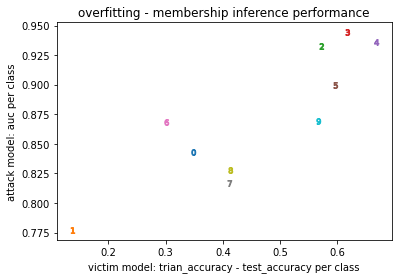

In [28]:
for i in range(10):
  plt.scatter(list(target_model_accuracy_per_label.values())[i],
              list(attack_model_auc_per_label.values())[i],
              marker=f"${i}$")
  
  plt.title("overfitting - membership inference performance")
  plt.xlabel("victim model: trian_accuracy - test_accuracy per class")
  plt.ylabel("attack model: auc per class")

  plt.savefig("membership_inference_overfitting.png")